This file is used to generate Fig S5

First, a random discrete random loci model is instantiated, then an adaptive dynamics model is made with a trade-off function fitted to the simulated pareto front.

In [459]:
import numpy as np
from scipy.integrate import solve_ivp

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

from model import PModel, ADModel

#Global parameters for Pareto front
n_loci = 9      #Number of loci
p1 = 0.3        #Probability of first-order epistatic interaction
p2 = 0.3        #Probability of second-order epistatic interaction
sigma1 = 0.3    #Standard deviation for first-order epistasis
sigma2 = 0.3    #Standard deviation for second-order epistasis
beta = 0.005    #Baseline transmission rate

#Parameters for evolutionary simulation
n_gens = 15
t = (0, 1000)

In [460]:
#Initialize discrete random loci model
cost = np.random.exponential(0.1, n_loci)
res = np.random.exponential(0.1, n_loci)

PF_model = PModel(n_loci, res, cost, beta=beta)
PF_model.normalize()

#Compute pareto front and interpolate from model
res_vals = np.linspace(0, np.max(PF_model.B), 100)
res_pts, fec_pts = PF_model.pareto()
fec_interp = np.interp(res_vals, res_pts, fec_pts)

coefs = np.polyfit(res_vals, fec_interp, 5)
fec_vals = np.poly1d(coefs)(res_vals)

In [461]:
#Initialize an adaptive dynamics model based on the trade-off function
AD_sim = ADModel(res=res_vals, b=fec_vals)
results = AD_sim.run_sim()

#run dynamical simulation
X_t, I_t = PF_model.run_sim(t, n_gens)

In [462]:
#Resample results into time and genotype bins to create a raster
n_res_bins = 15
n_time_bins = 15

evol_plot = np.zeros((n_res_bins, n_time_bins))
res_bins = np.linspace(0, PF_model.beta, n_res_bins)
time_bins = np.linspace(0, n_gens, n_time_bins)
time_vals = np.arange(0, n_gens)

for i in range(n_res_bins - 1):
    for j in range(n_time_bins - 1):
        evol_inds = np.logical_and(res_bins[i] < PF_model.B,PF_model.B <= res_bins[i+1])
        time_inds = np.logical_and(time_bins[j] < time_vals,time_vals <= time_bins[j+1])

        filter = np.outer(evol_inds, time_inds)

        if np.any(filter):
            evol_plot[i,j] = np.average(X_t[filter])

In [530]:
def label_x_ticks(ax, vals, n_ticks = 4):
    x_lim = ax.get_xlim()
    x_ticks = np.linspace(x_lim[0], x_lim[1], n_ticks)
    x_tick_labels = np.round(np.linspace(np.min(vals), np.max(vals), n_ticks), 3)

    ax.set_xticks(x_ticks, x_tick_labels)

def label_y_ticks(ax, vals, n_ticks = 4):
    y_lim = ax.get_ylim()
    y_ticks = np.linspace(y_lim[0], y_lim[1], n_ticks)
    y_tick_labels = np.round(np.linspace(np.min(vals), np.max(vals), n_ticks), 3)

    ax.set_yticks(y_ticks, y_tick_labels)

Text(-0.2, 1.1, 'C')

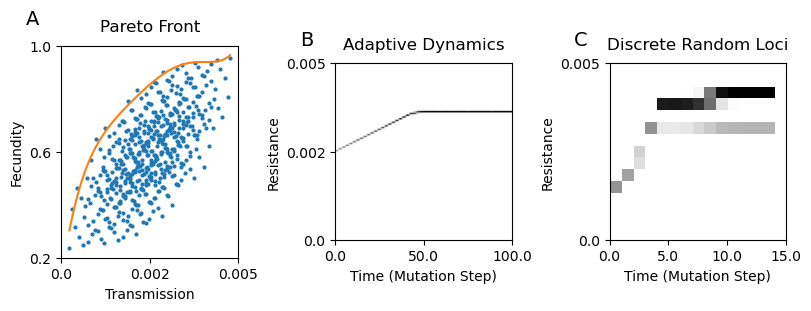

In [531]:
fig, ax = plt.subplots(ncols=3, figsize=(8, 3), layout='constrained')

ax[0].scatter(PF_model.B, PF_model.F, s=4)
ax[0].plot(res_vals, fec_vals, color='tab:orange')
ax[0].set_title('Pareto Front', pad=10)
ax[0].set_ylabel('Fecundity')
ax[0].set_xlabel('Transmission')

label_x_ticks(ax[0], PF_model.B, 3)
label_y_ticks(ax[0], PF_model.F, 3)

ax[1].imshow(results[0], extent=[0,1,0,1], cmap='Greys')
ax[1].set_title('Adaptive Dynamics', pad=10)
ax[1].set_ylabel('Resistance')
ax[1].set_xlabel('Time (Mutation Step)')

label_x_ticks(ax[1], np.linspace(0, 100, 5, dtype=np.uint), 3)
label_y_ticks(ax[1], res_vals, 3)

genotypes = ax[2].imshow(np.log(1+evol_plot), cmap='Greys')
ax[2].set_title('Discrete Random Loci', pad=10)
ax[2].set_ylabel('Resistance')
ax[2].set_xlabel('Time (Mutation Step)')

label_x_ticks(ax[2], np.linspace(0, n_time_bins, dtype=np.uint), 4)
label_y_ticks(ax[2], PF_model.B, 2)

ax[0].annotate("A", xy=(-0.2, 1.1), xycoords="axes fraction", fontsize=14)
ax[1].annotate("B", xy=(-0.2, 1.1), xycoords="axes fraction", fontsize=14)
ax[2].annotate("C", xy=(-0.2, 1.1), xycoords="axes fraction", fontsize=14)

Invasion plots

In [465]:
def S_star(beta, mu=0.2):
    return mu / beta

def I_star(beta, b, mu=0.2, k=0.001):
    return (beta*(b - mu) - k*mu) / (beta*(k + beta))

def invasion_fitness(b_res, beta_res, b_mut, beta_mut, mu=0.2, k=0.001):
    return b_mut - mu - k*(S_star(beta_res) + I_star(beta_res, b_res)) - beta_mut*I_star(beta_res, b_res)

In [495]:
res_pareto, fec_pareto = PF_model.pareto()
fec_pareto = fec_pareto[res_pareto > 0]
res_pareto = res_pareto[res_pareto > 0]

dim_pareto = len(res_pareto)

PIP_pareto = np.zeros((dim_pareto, dim_pareto))

for i in range(dim_pareto):
    for j in range(dim_pareto):
        diff = invasion_fitness(fec_pareto[i], res_pareto[i], fec_pareto[j], res_pareto[j])
        if diff > 0:
            PIP_pareto[i, j] = 2
        elif diff < 0:
            PIP_pareto[i, j] = 0
        
        if i == j:
            PIP_pareto[i, j] = 1

dim_approx = 1000

PIP_approx = np.zeros((dim_approx, dim_approx))

res_approx = np.linspace(np.min(res_pareto), np.max(res_pareto), dim_approx)
fec_interp = np.interp(res_approx, res_pareto, fec_pareto)

coefs = np.polyfit(res_approx, fec_interp, 5)
fec_approx = np.poly1d(coefs)(res_approx)

for i in range(dim_approx):
    for j in range(dim_approx):
        diff = invasion_fitness(fec_approx[i], res_approx[i], fec_approx[j], res_approx[j])
        if diff > 0:
            PIP_approx[i, j] = 2
        elif diff < 0:
            PIP_approx[i, j] = 0
        
        if i == j:
            PIP_approx[i, j] = 1

Text(-0.2, 1.1, 'B')

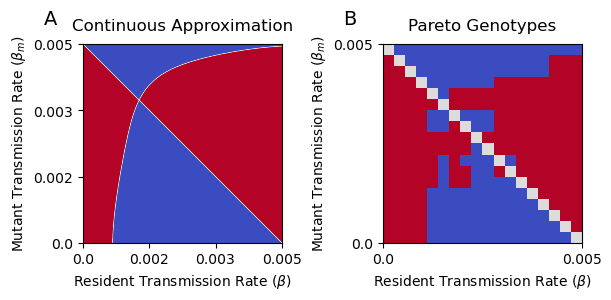

In [533]:
fig, ax = plt.subplots(ncols=2, figsize=(6, 3), layout='constrained')

ax[0].imshow(PIP_approx.T, cmap='coolwarm')
ax[1].imshow(PIP_pareto.T, cmap='coolwarm')

label_x_ticks(ax[0], res_approx)
label_y_ticks(ax[0], res_approx)
label_x_ticks(ax[1], res_pareto, n_ticks=2)
label_y_ticks(ax[1], res_pareto, n_ticks=2)

ax[0].set_xlabel(r'Resident Transmission Rate ($\beta$)')
ax[0].set_ylabel(r'Mutant Transmission Rate ($\beta_m$)')

ax[1].set_xlabel(r'Resident Transmission Rate ($\beta$)')
ax[1].set_ylabel(r'Mutant Transmission Rate ($\beta_m$)')

ax[0].set_title('Continuous Approximation', pad=10)
ax[1].set_title('Pareto Genotypes', pad=10)

ax[0].annotate("A", xy=(-0.2, 1.1), xycoords="axes fraction", fontsize=14)
ax[1].annotate("B", xy=(-0.2, 1.1), xycoords="axes fraction", fontsize=14)